# Dialogue and Scene Data Processing Notebook

This notebook provides a comprehensive pipeline for processing dialogue and scene data from literary works. It includes steps for:

- Processing character information
- Extracting and organizing dialogues and scenes
- Building interaction networks between characters
- Compiling detailed character profiles
- Analyzing the introduction of new characters by chapter and attributes
- Creating a detailed per-chapter summary including the Bechdel Test

By following this notebook, you will transform raw dialogue data into structured CSV files suitable for analysis and visualization.

## 1. Importing Required Libraries

We begin by importing the necessary Python libraries for data manipulation, sentiment analysis, and handling data structures.

In [410]:
import pandas as pd
from textblob import TextBlob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style for better aesthetics
sns.set(style="whitegrid")

## 2. Setting Up the Environment

Ensure that the directories for saving CSV files exist. If not, create them to avoid any file saving errors.

In [411]:
# Define the directory path for saving CSV files
output_dir = 'src/data/csv/'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

## 3. Defining Helper Functions

We define several helper functions to process characters, interactions, extract character information, and evaluate the Bechdel Test from the dialogues and scenes data.

In [412]:
def process_character(characters_dict, character_info):
    """
    Process a character from the characters dictionary and a character info dictionary.

    Parameters:
    - characters_dict (dict): A dictionary of characters.
    - character_info (dict or str): A character info dictionary or a character name.

    Returns:
    - dict: A processed character dictionary.
    """
    if isinstance(character_info, dict):
        name = character_info.get('name')
        # Create a copy to avoid mutating the original characters_dict
        character = characters_dict.get(name, {'name': name}).copy()
        character.update(character_info)
    else:
        name = character_info
        character = characters_dict.get(name, {'name': name}).copy()
    return character

def process_characters_list(characters_dict, characters_list):
    """
    Process a list of characters using the process_character function.

    Parameters:
    - characters_dict (dict): A dictionary of characters.
    - characters_list (list): A list of character info dictionaries or names.

    Returns:
    - list: A list of processed character dictionaries.
    """
    if not characters_list:
        return []
    return [process_character(characters_dict, info) for info in characters_list]

def process_interactions(speaker, interactions, interaction_type, word_count):
    """
    Process interactions and return a list of interaction data.

    Parameters:
    - speaker (dict or str): Speaker information.
    - interactions (list): List of interactions (could be dicts or strings).
    - interaction_type (str): Type of interaction ('direct', 'indirect', 'mention', 'talk_about').
    - word_count (int): Word count of the dialogue.

    Returns:
    - List of interaction data to be appended to network_data.
    """
    speaker_name = speaker.get('name') if isinstance(speaker, dict) else speaker
    speaker_titles = speaker.get('title(s)', None) if isinstance(speaker, dict) else None
    speaker_houses = speaker.get('house(s)', None) if isinstance(speaker, dict) else None
    speaker_gender = speaker.get('gender') if isinstance(speaker, dict) else None
    speaker_age = speaker.get('age') if isinstance(speaker, dict) else None
    speaker_culture = speaker.get('culture') if isinstance(speaker, dict) else None

    interaction_data = []
    for interaction in interactions:
        # Extract interaction details based on type
        if isinstance(interaction, dict):
            interaction_name = interaction.get('name')
            interaction_titles = interaction.get('title(s)', None)
            interaction_houses = interaction.get('house(s)', None)
            interaction_gender = interaction.get('gender', None)
            interaction_age = interaction.get('age', None)
            interaction_culture = interaction.get('culture', None)
        else:
            interaction_name = interaction
            interaction_titles = None
            interaction_houses = None
            interaction_gender = None
            interaction_age = None
            interaction_culture = None

        # Skip invalid or unknown interactions
        if interaction_name and not interaction_name.startswith('Unknown ('):
            # Initialize interaction data with default zeros
            data = [
                speaker_name, speaker_titles, speaker_houses, speaker_gender,
                speaker_age, speaker_culture, interaction_name, interaction_titles,
                interaction_houses, interaction_gender, interaction_age, interaction_culture,
                0, 0, 0, 0, 0, 0
            ]
            # Update interaction counts based on type
            if interaction_type == 'direct':
                data[12] = 1             # direct_lines
                data[13] = word_count    # direct_words
            elif interaction_type == 'indirect':
                data[14] = 1             # indirect_lines
                data[15] = word_count    # indirect_words
            elif interaction_type == 'mention':
                data[16] = 1             # mentions
            elif interaction_type == 'talk_about':
                data[17] = 1             # talk_about
            interaction_data.append(data)
    return interaction_data

def get_characters_info(df):
    """
    Extract unique characters and their information, including first appearance and interaction counts.

    Parameters:
    - df (DataFrame): DataFrame containing dialogue data.

    Returns:
    - Dictionary of characters with their information.
    """
    characters = {}

    for index, row in df.iterrows():
        book = row['book_name']
        chapter_title = row['chapter_title']
        chapter_number = row['chapter_number']
        word_count = row['dialogue_word_count']
        
        # Helper function to process a character or list of characters
        def process_char_info(char_info, role):
            if not char_info:
                return
            if isinstance(char_info, list):
                for char in char_info:
                    process_char_info(char, role)
            else:
                if isinstance(char_info, dict):
                    name = char_info.get('name')
                    char_attributes = char_info.copy()
                else:
                    name = char_info
                    char_attributes = {'name': name}
                if name and not name.startswith('Unknown ('):
                    # Initialize character data if not present or attributes have changed
                    if (name not in characters or
                        characters[name]['titles'] != char_attributes.get('title(s)', None) or
                        characters[name]['houses'] != char_attributes.get('house(s)', None) or
                        characters[name]['gender'] != char_attributes.get('gender', None) or
                        characters[name]['age'] != char_attributes.get('age', None) or
                        characters[name]['culture'] != char_attributes.get('culture', None)):
                        # Initialize character data
                        char_data = {
                            'name': name,
                            'titles': char_attributes.get('title(s)', None),
                            'houses': char_attributes.get('house(s)', None),
                            'gender': char_attributes.get('gender', None),
                            'age': char_attributes.get('age', None),
                            'culture': char_attributes.get('culture', None),
                            'first_appearance_book': book,
                            'first_appearance_chapter': chapter_title,
                            'first_appearance_chapter_number': chapter_number,
                            'num_speeches': 0,
                            'num_words_spoken': 0,
                            'num_addressee': 0,
                            'num_listener': 0,
                            'num_mentions': 0,
                            'num_about': 0,
                        }
                        characters[name] = char_data
                    # Update counts based on role
                    if role == 'speaker':
                        characters[name]['num_speeches'] += 1
                        characters[name]['num_words_spoken'] += word_count
                    elif role == 'addressee':
                        characters[name]['num_addressee'] += 1
                    elif role == 'listener':
                        characters[name]['num_listener'] += 1
                    elif role == 'mention':
                        characters[name]['num_mentions'] += 1
                    elif role == 'about':
                        characters[name]['num_about'] += 1

        # Process speaker
        process_char_info(row['dialogue_speaker'], 'speaker')
        # Process addressees, listeners, mentions, about_characters
        process_char_info(row.get('dialogue_addressees', []), 'addressee')
        process_char_info(row.get('dialogue_listeners', []), 'listener')
        process_char_info(row.get('dialogue_mentions', []), 'mention')
        process_char_info(row.get('dialogue_about_characters', []), 'about')

    return characters

def bechdel_test_dialogue(dialogue_text, speaker, addressees, about_characters):
    """
    Determine if a dialogue passes the Bechdel Test.

    Parameters:
    - dialogue_text (str): The text of the dialogue.
    - speaker (dict): Speaker dictionary.
    - addressees (list of dict): List of addressee dictionaries.

    Returns:
    - bool: True if the dialogue passes the Bechdel Test, False otherwise.
    """

    # Identify female speakers and addressees
    female_speakers = [speaker] if speaker.get('gender') == 'Female' else []
    female_addressees = [a for a in addressees if a.get('gender') == 'Female']

    # Total unique female characters in the dialogue
    unique_female_interactors = set([s['name'] for s in female_speakers] + [a['name'] for a in female_addressees])

    if len(unique_female_interactors) < 2:
        return False  # Less than two women

    # Simple keyword check to determine if not about a man
    # This can be replaced with a more sophisticated NLP approach
    if any([a.get('gender') == 'Male' for a in about_characters]):
        return False  # Dialogue is about a man

    return True  # Passes the test

def bechdel_test_scene(dialogues_in_scene):
    """
    Determine if a scene passes the Bechdel Test based on its dialogues.

    Parameters:
    - dialogues_in_scene (List of dict): List of dialogues in the scene.

    Returns:
    - bool: True if the scene passes the Bechdel Test, False otherwise.
    - float: Percentage of dialogues that pass the Bechdel Test.
    """
    # Count the number of dialogues that pass the Bechdel
    num_dialogues = len(dialogues_in_scene)
    num_passing_dialogues = sum([d['dialogue_bechdel_pass'] for d in dialogues_in_scene])

    # Calculate the percentage of dialogues that pass the Bechdel Test
    percentage_passing = num_passing_dialogues / num_dialogues if num_dialogues > 0 else 0.0

    # Check if the scene passes the Bechdel Test
    return percentage_passing >= 0.5, percentage_passing

def bechdel_test_chapter(scenes_in_chapter):
    """
    Determine if a chapter passes the Bechdel Test based on its scenes.

    Parameters:
    - scenes_in_chapter (DataFrame): DataFrame containing scenes in the chapter.

    Returns:
    - bool: True if the chapter passes the Bechdel Test, False otherwise.
    """
    # Check if any scene in the chapter passes the Bechdel Test
    return scenes_in_chapter['scene_bechdel_pass'].any()


## 4. Loading the Data

Before processing, ensure that your `dialogues_data` is loaded into the notebook. This data should be a list of dictionaries representing books, chapters, scenes, and dialogues.

*Note:* Replace the placeholder code with the actual data loading mechanism as per your data source (e.g., JSON file, database, etc.).

In [413]:
with open('src/data/json/dialogues.json', 'r', encoding='utf-8') as file:
    dialogues_data = json.load(file)

## 5. Processing Dialogues and Scenes

We iterate through the `dialogues_data` to extract and process information about scenes and dialogues. This includes:

- Extracting scene details such as book name, chapter information, location, time, number of dialogues, gender counts, and themes.
- Extracting dialogue details including speaker, addressees, listeners, mentions, topics, sentiment analysis, and word counts.
- Performing the Bechdel Test for each dialogue and scene.

The processed data is then stored in separate DataFrames and exported as CSV files.

In [414]:
# Initialize lists to store dialogue and scene information
dialogues_list = []
scenes_list = []

# Initialize an empty dictionary for characters (used in processing dialogues)
# This assumes that characters_dict is provided or can be constructed from dialogues_data
# If not available, initialize as empty and build as needed
characters_dict = {}

# Iterate through each entry in dialogues_data
for entry in dialogues_data:
    book = entry.get('book')
    chapter = entry.get('chapter')
    title = entry.get('title')
    year = entry.get('year')
    scenes = entry.get('scenes', [])

    # Iterate through each scene in the current entry
    for scene in scenes:
        scene_id = scene.get('id')
        location = scene.get('location')
        time = scene.get('time')
        characters = scene.get('characters', {}).copy()  # Make a copy to avoid mutating the original
        other_characters = scene.get('other_characters', {})
        
        # Merge other_characters into characters if present
        if other_characters:
            characters.update(other_characters)
        
        dialogues = scene.get('dialogues', [])
        
        # Count the number of dialogues in the scene
        num_dialogues = len(dialogues)
        
        # Count the number of male and female characters in the scene
        male_count = 0
        female_count = 0
        for character in characters.values():
            gender = character.get('gender')
            if gender == 'Male':
                male_count += 1
            elif gender == 'Female':
                female_count += 1
        
        # Get the themes of the scene
        themes = scene.get('theme(s)', [])
        
        # Collect scene information
        scenes_list.append({
            'book_name': book,
            'chapter_title': title,
            'chapter_number': chapter,
            'scene_id': scene_id,
            'location': location,
            'time': time,
            'num_dialogues': num_dialogues,
            'num_males': male_count,
            'num_females': female_count,
            'themes': themes,
            'scene_bechdel_pass': False,
            'scene_bechdel_percent': 0.0
        })
        
        # Iterate through each dialogue in the current scene
        for dialogue in dialogues:
            # Process the speaker
            speaker_info = dialogue.get('speaker')
            speaker = process_character(characters, speaker_info)
            
            # Process the addressees
            addressees_info = dialogue.get('addressee(s)', [])
            addressees = process_characters_list(characters, addressees_info)
            
            # Process the listeners
            listeners_info = dialogue.get('listener(s)', [])
            listeners = process_characters_list(characters, listeners_info)
            
            # Process the mentions
            mentions_info = dialogue.get('mention(s)', [])
            mentions = process_characters_list(characters, mentions_info)
            
            # Process the about_characters
            about_characters_info = dialogue.get('about character(s)', [])
            about_characters = process_characters_list(characters, about_characters_info)
            
            # Extract the dialogue text
            text = dialogue.get('text', '')
            
            # Compute sentiment polarity using TextBlob
            sentiment = TextBlob(text).sentiment.polarity
            
            # Collect dialogue information
            dialogues_list.append({
                'book_name': book,
                'chapter_number': chapter,
                'chapter_title': title,
                'chapter_year': year,
                'scene_id': scene_id,
                'scene_location': location,
                'scene_time': time,
                'dialogue_text': text,
                'dialogue_speaker': speaker,
                'dialogue_addressees': addressees,
                'dialogue_listeners': listeners,
                'dialogue_mentions': mentions,
                'dialogue_about_characters': about_characters,
                'dialogue_word_count': len(text.split()),
                'dialogue_sentiment': sentiment,
                'dialogue_bechdel_pass': bechdel_test_dialogue(text, speaker, addressees, about_characters),
            })
        
        # Update the scene Bechdel Test status based on dialogues
        scene_pass_bechdel, scene_percent_bechdel = bechdel_test_scene(dialogues_list[-num_dialogues:])
        scenes_list[-1]['scene_bechdel_pass'] = scene_pass_bechdel
        scenes_list[-1]['scene_bechdel_percent'] = scene_percent_bechdel

# Create a DataFrame from the dialogues list
dialogues_df = pd.DataFrame(dialogues_list)

# Create a DataFrame from the scenes list
scenes_df = pd.DataFrame(scenes_list)

# Save the dialogues and scenes DataFrames to CSV files
dialogues_df.to_csv(os.path.join(output_dir, 'dialogues.csv'), index=False)
scenes_df.to_csv(os.path.join(output_dir, 'scenes.csv'), index=False)

# Display the first 10 rows of the dialogues DataFrame
print("Dialogues DataFrame (first 10 rows):")
display(dialogues_df.head())

# Display the first few rows of the scenes DataFrame
print("\nScenes DataFrame (first 5 rows):")
display(scenes_df.head())

Dialogues DataFrame (first 10 rows):


,book_name,chapter_number,chapter_title,chapter_year,scene_id,scene_location,scene_time,dialogue_text,dialogue_speaker,dialogue_addressees,dialogue_listeners,dialogue_mentions,dialogue_about_characters,dialogue_word_count,dialogue_sentiment,dialogue_bechdel_pass
0,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,We should start back. The wildlings are dead.,"{'name': 'Gared', 'house(s)': None, 'title(s)'...","[{'name': 'Waymar Royce', 'house(s)': ['Royce'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",[],[],8,-0.1,False
1,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,Do the dead frighten you?,"{'name': 'Waymar Royce', 'house(s)': ['Royce']...","[{'name': 'Gared', 'house(s)': None, 'title(s)...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",[],[],5,-0.2,False
2,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,Dead is dead. We have no business with the dead.,"{'name': 'Gared', 'house(s)': None, 'title(s)'...","[{'name': 'Waymar Royce', 'house(s)': ['Royce'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",[],[],10,-0.2,False
3,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,Are they dead? What proof have we?,"{'name': 'Waymar Royce', 'house(s)': ['Royce']...","[{'name': 'Gared', 'house(s)': None, 'title(s)...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",[],[],7,-0.2,False
4,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,"Will saw them. If he says they are dead, that'...","{'name': 'Gared', 'house(s)': None, 'title(s)'...","[{'name': 'Waymar Royce', 'house(s)': ['Royce'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",14,-0.1,False



Scenes DataFrame (first 5 rows):


,book_name,chapter_title,chapter_number,scene_id,location,time,num_dialogues,num_males,num_females,themes,scene_bechdel_pass,scene_bechdel_percent
0,A Game of Thrones,Prologue,0,0,The Haunted Forest,Evening,36,5,2,"[Fear, Death, Cold, Duty, Experience vs. Youth]",False,0.0
1,A Game of Thrones,Prologue,0,1,The Haunted Forest,Evening,17,3,0,"[Fear, Supernatural, Duty, Experience vs. Youth]",False,0.0
2,A Game of Thrones,Prologue,0,2,The Haunted Forest,Evening,12,3,0,"[Supernatural, Fear, Death, Courage, Honor]",False,0.0
3,A Game of Thrones,Bran I,1,0,Outside Winterfell,Morning,4,11,0,"[Justice, Honor, Duty, Courage]",False,0.0
4,A Game of Thrones,Bran I,1,1,Outside Winterfell,Morning,4,4,0,"[Courage vs. Fear, Brotherhood, Perception of ...",False,0.0


## 6. Processing Network Data

We build a network of interactions between characters based on the dialogues. This includes various types of interactions such as direct lines, indirect lines, mentions, and topics of conversation. The network data is aggregated and exported as a CSV file for further analysis.

In [415]:
# Initialize list to store network interaction data
network_data = []

# Iterate through each row in dialogues_df to build network_data
for index, row in dialogues_df.iterrows():
    # Extract speaker information
    speaker_info = row['dialogue_speaker']
    speaker_name = speaker_info.get('name') if isinstance(speaker_info, dict) else speaker_info

    # Continue only if speaker is valid
    if speaker_name and not speaker_name.startswith('Unknown ('):
        word_count = row['dialogue_word_count']
        
        # Process each type of interaction and extend network_data
        addressees = row.get('dialogue_addressees', []) or []
        network_data.extend(process_interactions(speaker_info, addressees, 'direct', word_count))
        
        listeners = row.get('dialogue_listeners', []) or []
        network_data.extend(process_interactions(speaker_info, listeners, 'indirect', word_count))
        
        mentions = row.get('dialogue_mentions', []) or []
        network_data.extend(process_interactions(speaker_info, mentions, 'mention', word_count))
        
        about_characters = row.get('dialogue_about_characters', []) or []
        network_data.extend(process_interactions(speaker_info, about_characters, 'talk_about', word_count))

# Create DataFrame from network_data
network_df = pd.DataFrame(network_data, columns=[
    'source_name', 'source_titles', 'source_houses', 'source_gender', 'source_age', 'source_culture',
    'target_name', 'target_titles', 'target_houses', 'target_gender', 'target_age', 'target_culture',
    'direct_lines', 'direct_words', 'indirect_lines', 'indirect_words', 'mentions', 'talk_about'
])

# Convert list columns to tuples to make them hashable for grouping
list_columns = ['source_titles', 'source_houses', 'target_titles', 'target_houses']

for col in list_columns:
    network_df[col] = network_df[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Define grouping columns for aggregation
grouping_columns = [
    'source_name', 'source_titles', 'source_houses', 'source_gender', 'source_age', 'source_culture',
    'target_name', 'target_titles', 'target_houses', 'target_gender', 'target_age', 'target_culture'
]

# Group by the defined columns and sum the interaction counts
network_df_grouped = network_df.groupby(grouping_columns, as_index=False, dropna=False).sum()

# (Optional) Convert tuple columns back to lists for readability
for col in list_columns:
    network_df_grouped[col] = network_df_grouped[col].apply(lambda x: list(x) if isinstance(x, tuple) else x)

# Save the grouped network DataFrame to a CSV file
network_df_grouped.to_csv(os.path.join(output_dir, 'network.csv'), index=False)

# Display the first few rows of the network DataFrame
print("\nNetwork DataFrame (first 5 rows):")
display(network_df_grouped.head())


Network DataFrame (first 5 rows):


,source_name,source_titles,source_houses,source_gender,source_age,source_culture,target_name,target_titles,target_houses,target_gender,target_age,target_culture,direct_lines,direct_words,indirect_lines,indirect_words,mentions,talk_about
0,Arya Stark,[Princess],[Stark],Female,0 - 10,Northmen,Beth Cassel,NaN,[Cassel],Female,0 - 10,Northmen,1,7,5,23,0,0
1,Arya Stark,[Princess],[Stark],Female,0 - 10,Northmen,Bran Stark,[Prince],[Stark],Male,0 - 10,Northmen,0,0,0,0,1,2
2,Arya Stark,[Princess],[Stark],Female,0 - 10,Northmen,Jeyne Poole,NaN,[Poole],Female,11 - 20,Northmen,1,7,5,23,0,0
3,Arya Stark,[Princess],[Stark],Female,0 - 10,Northmen,Joffrey Baratheon,[Prince],"[Baratheon, Lannister]",Male,11 - 20,Crownlands,0,0,0,0,1,3
4,Arya Stark,[Princess],[Stark],Female,0 - 10,Northmen,Jon Snow,NaN,NaN,Male,11 - 20,Northmen,22,202,1,3,2,2


## 7. Extracting Characters Information

We extract detailed information about each unique character, including their titles, houses, gender, age, culture, first appearance, and interaction counts. This data is compiled into a separate DataFrame and exported as a CSV file.

In [416]:
# Get the characters information using the get_characters_info function
characters_info = get_characters_info(dialogues_df)

# Convert the characters_info dictionary to a DataFrame
characters_df = pd.DataFrame.from_dict(characters_info, orient='index')

# Reset index to have 'name' as a column
characters_df.reset_index(drop=True, inplace=True)

# Sort the DataFrame by 'name' for better readability
characters_df.sort_values('name', inplace=True)

# Save the characters DataFrame to a CSV file
characters_df.to_csv(os.path.join(output_dir, 'characters.csv'), index=False)

# Display the first few rows of the characters DataFrame
print("\nCharacters DataFrame (first 5 rows):")
display(characters_df.head())


Characters DataFrame (first 5 rows):


,name,titles,houses,gender,age,culture,first_appearance_book,first_appearance_chapter,first_appearance_chapter_number,num_speeches,num_words_spoken,num_addressee,num_listener,num_mentions,num_about
57,Aegon I Targaryen,"[King, Lord, Protector, Shield]",[Targaryen],Male,31 - 40,Crownlands,A Game of Thrones,Daenerys I,3,0,0,0,0,1,1
46,Aegon Targaryen (son of Rhaegar),[Prince],[Targaryen],Male,0 - 10,Crownlands,A Game of Thrones,Daenerys I,3,0,0,0,0,0,1
49,Aerys II Targaryen,"[King, Lord, Prince, Protector]",[Targaryen],Male,31 - 40,Crownlands,A Game of Thrones,Daenerys I,3,0,0,0,0,0,2
21,Arya Stark,[Princess],[Stark],Female,0 - 10,Northmen,A Game of Thrones,Bran I,1,30,236,37,6,3,9
74,Ayrmidon,None,None,Male,None,Valyrian,A Game of Thrones,Tyrion I,9,0,0,0,0,1,1


## 8. Analyzing Character Introductions by Attributes

Understanding how new characters are introduced throughout the story can provide valuable insights into the narrative structure and character development. In this section, we will analyze the appearance of new characters by chapter based on various attributes such as gender, age, nobility (house ownership), rank (title possession), and culture. This includes:

- **Frequency of New Character Introductions:** How many new characters appear in each chapter.
- **Types of Characters Introduced:** Categorizing new characters based on attributes like gender, age, nobility, rank, and culture.
- **Cumulative Character Growth:** Tracking the total number of unique characters as the story progresses.
- **Visualization of Character Introductions:** Creating separate plots for each attribute type to visualize their introduction trends individually with associated pastel colors.

This analysis will help in identifying pivotal chapters where significant character introductions occur and understanding the diversity of characters as the story unfolds.

### 8.1 Preparing the Data for Analysis

We begin by ensuring that the `characters_df` DataFrame contains all necessary columns and handling any missing data.

In [417]:
# Ensure that characters_df contains the necessary columns for analysis
required_columns = [
    'name', 'first_appearance_chapter_number', 'titles',
    'houses', 'gender', 'age', 'culture'
]
missing_columns = [col for col in required_columns if col not in characters_df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing in characters_df: {missing_columns}")

# Extract first appearance information
characters_first_appearance = characters_df[['name', 'first_appearance_chapter_number', 'titles', 'houses', 'gender', 'age', 'culture']].copy()

# Handle missing chapter numbers
characters_first_appearance = characters_first_appearance.dropna(subset=['first_appearance_chapter_number'])

# Convert chapter numbers to integers if they are not already
characters_first_appearance['first_appearance_chapter_number'] = characters_first_appearance['first_appearance_chapter_number'].astype(int)

# Determine the total number of chapters
total_chapters = dialogues_df['chapter_number'].max()

### 8.2 Counting New Characters Introduced per Chapter

We count how many new characters are introduced in each chapter.

In [418]:
# Initialize a DataFrame to hold new character counts per chapter
new_characters_per_chapter = pd.DataFrame({
    'chapter_number': range(0, total_chapters + 1),
    'new_characters': 0,
    'new_males': 0,
    'new_females': 0
})

# Count new characters introduced in each chapter
new_char_counts = characters_first_appearance.groupby('first_appearance_chapter_number').size().reset_index(name='new_characters_count')
new_characters_per_chapter = new_characters_per_chapter.merge(
    new_char_counts,
    left_on='chapter_number',
    right_on='first_appearance_chapter_number',
    how='left'
)

# Replace NaN with 0 and add the new counts
new_characters_per_chapter['new_characters'] += new_characters_per_chapter['new_characters_count'].fillna(0).astype(int)
new_characters_per_chapter.drop(['new_characters_count', 'first_appearance_chapter_number'], axis=1, inplace=True)

# Count new males introduced in each chapter
new_males = characters_first_appearance[characters_first_appearance['gender'] == 'Male'] \
    .groupby('first_appearance_chapter_number').size().reset_index(name='new_males_count')
new_characters_per_chapter = new_characters_per_chapter.merge(
    new_males,
    left_on='chapter_number',
    right_on='first_appearance_chapter_number',
    how='left'
)
new_characters_per_chapter['new_males'] += new_characters_per_chapter['new_males_count'].fillna(0).astype(int)
new_characters_per_chapter.drop(['new_males_count', 'first_appearance_chapter_number'], axis=1, inplace=True)

# Count new females introduced in each chapter
new_females = characters_first_appearance[characters_first_appearance['gender'] == 'Female'] \
    .groupby('first_appearance_chapter_number').size().reset_index(name='new_females_count')
new_characters_per_chapter = new_characters_per_chapter.merge(
    new_females,
    left_on='chapter_number',
    right_on='first_appearance_chapter_number',
    how='left'
)
new_characters_per_chapter['new_females'] += new_characters_per_chapter['new_females_count'].fillna(0).astype(int)
new_characters_per_chapter.drop(['new_females_count', 'first_appearance_chapter_number'], axis=1, inplace=True)

# Calculate cumulative number of characters over chapters
new_characters_per_chapter['cumulative_characters'] = new_characters_per_chapter['new_characters'].cumsum()

# Save the chapter character counts to a CSV file
new_characters_per_chapter.to_csv(os.path.join(output_dir, 'new_characters_per_chapter.csv'), index=False)

# Display the corrected DataFrame
print("\nNew Characters per Chapter DataFrame (corrected):")
display(new_characters_per_chapter)


New Characters per Chapter DataFrame (corrected):


,chapter_number,new_characters,new_males,new_females,cumulative_characters
0,0,5,5,0,5
1,1,19,10,3,24
2,2,13,10,3,37
3,3,17,14,3,54
4,4,5,4,1,59
5,5,3,2,1,62
6,6,0,0,0,62
7,7,6,3,3,68
8,8,3,3,0,71
9,9,4,3,1,75


### 8.3 Categorizing Characters Based on Attributes

We categorize characters based on their attributes such as gender, age, nobility (house ownership), rank (title possession), and culture to analyze the diversity of character introductions.

In [419]:
# Function to categorize characters based on attributes
def categorize_character(row):
    categories = []
    if row['gender']:
        categories.append(f"{row['gender']} Character")
    if row['age']:
        categories.append(f"Age {row['age']}")
    if row['houses']:
        categories.append('House Member')
    else:
        categories.append('No House')
    if row['titles']:
        categories.append('Title Holder')
    else:
        categories.append('No Title')
    if row['culture']:
        categories.append(f"Culture: {row['culture']}")
    if not categories:
        categories.append('Other')
    return categories

# Apply categorization to each character
characters_first_appearance['categories_list'] = characters_first_appearance.apply(categorize_character, axis=1)

# Explode the categories to have one category per row
exploded_categories = characters_first_appearance.explode('categories_list')

# Remove any leading/trailing whitespace
exploded_categories['categories_list'] = exploded_categories['categories_list'].str.strip()

# Get unique categories
unique_categories = exploded_categories['categories_list'].unique()

### 8.4 Plotting New Characters Introduced by Gender

This plot shows the number of new characters introduced in each chapter based on their gender with associated pastel colors.

<Figure size 1400x700 with 0 Axes>

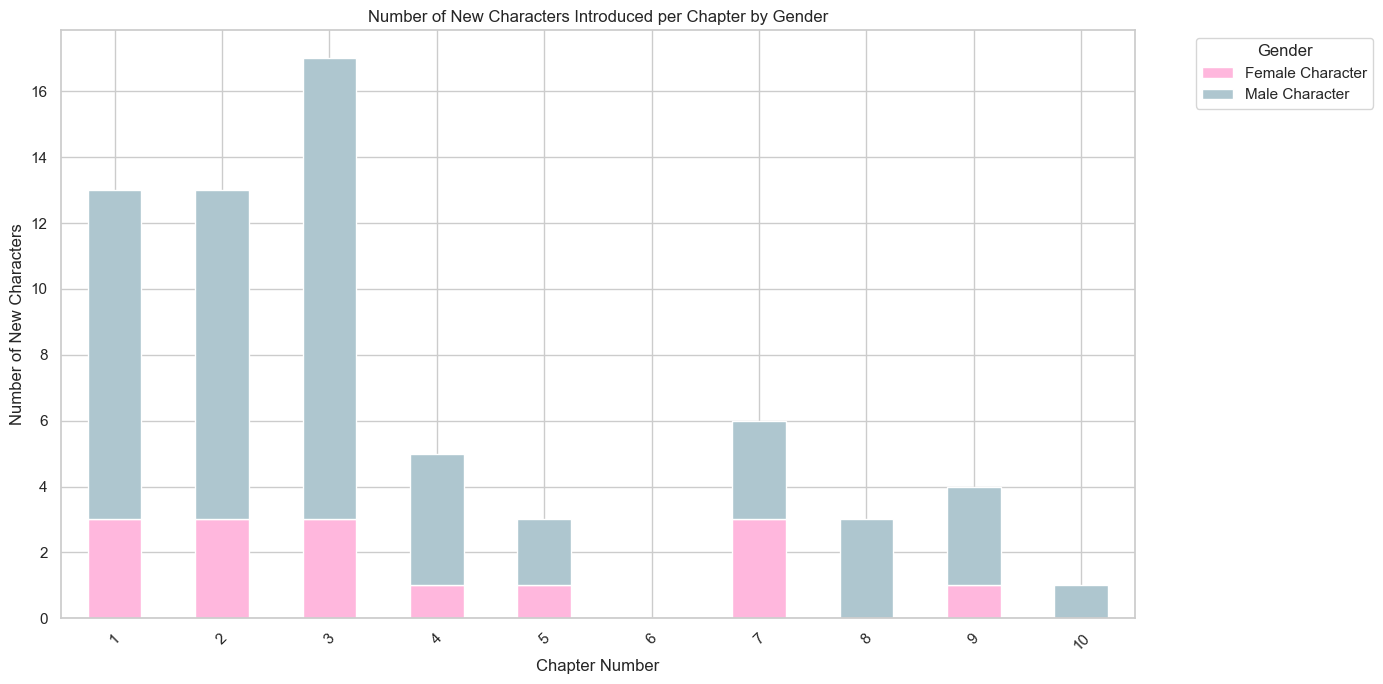

In [ ]:
# Define pastel colors for genders
gender_colors = {
    'Male Character': '#AEC6CF', # Pastel Blue
    'Female Character': '#FFB7DD',  # Pastel Pink
    'Other': '#CFCFC4' # Pastel Gray
}

# Define relevant gender categories 
gender_categories = ['Male Character', 'Female Character', 'Other']

# Filter for gender categories
gender_data = exploded_categories[exploded_categories['categories_list'].isin(gender_categories)]

# Count new characters per gender and chapter
gender_counts = gender_data.groupby(['first_appearance_chapter_number', 'categories_list']).size().reset_index(name='count')

# Pivot the data to have genders as columns
gender_pivot = gender_counts.pivot(index='first_appearance_chapter_number', columns='categories_list', values='count').fillna(0)

# Reindex to include all chapters
gender_pivot = gender_pivot.reindex(range(1, total_chapters + 1), fill_value=0)

# Plotting Gender
plt.figure(figsize=(14, 7))
gender_pivot.plot(kind='bar', stacked=True, figsize=(14,7), color=[gender_colors.get(g, '#FFFFFF') for g in gender_pivot.columns])
plt.title('Number of New Characters Introduced per Chapter by Gender')
plt.xlabel('Chapter Number')
plt.ylabel('Number of New Characters')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8.5 Plotting New Characters Introduced by Age

This plot shows the number of new characters introduced in each chapter based on their age with associated pastel colors.

<Figure size 1400x700 with 0 Axes>

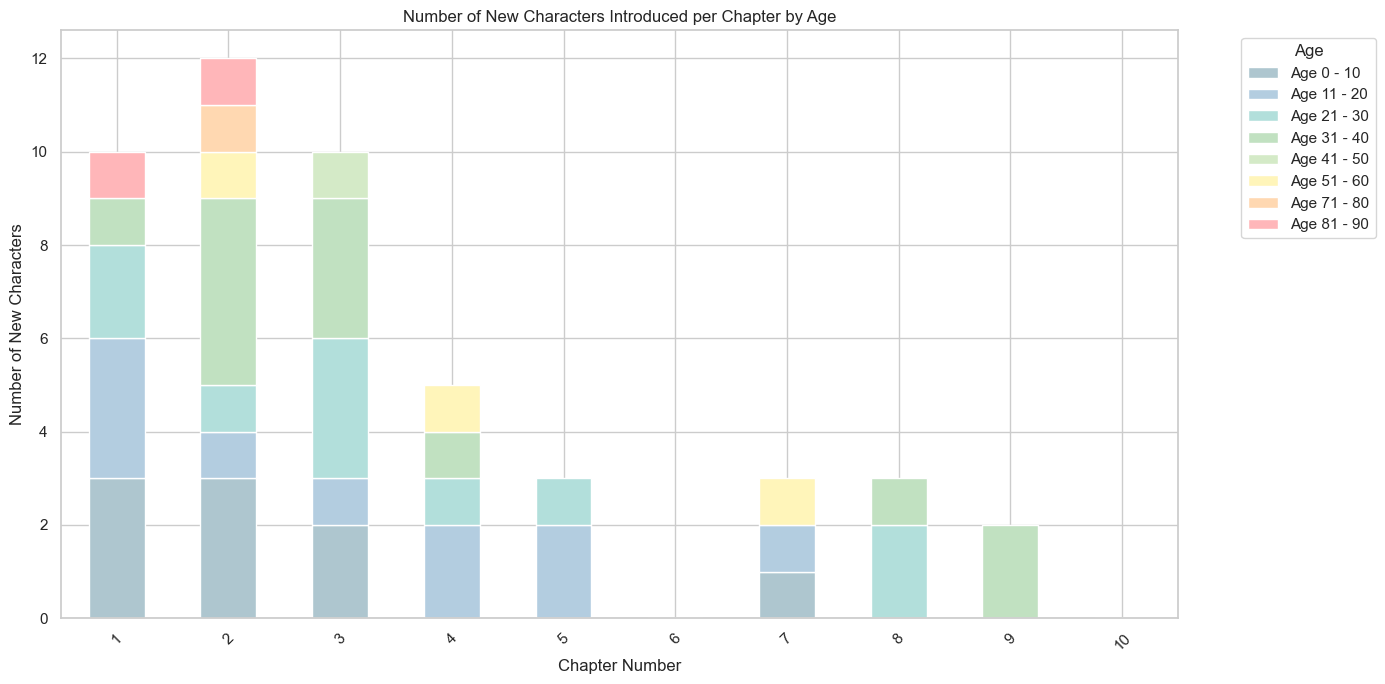

In [421]:
# Define pastel colors for ages (from light blue to light red 12 colors)

age_palette = {
    'Age 0 - 10': '#AEC6CF',  # Pastel Blue
    'Age 11 - 20': '#B3CDE0',  # Light Blue
    'Age 21 - 30': '#B2DFDB',  # Pastel Turquoise
    'Age 31 - 40': '#C1E1C1',  # Mint Green
    'Age 41 - 50': '#D4EAC7',  # Pale Green
    'Age 51 - 60': '#FFF5BA',  # Pastel Yellow
    'Age 61 - 70': '#FFF9C4',  # Light Yellow
    'Age 71 - 80': '#FFD8B1',  # Pastel Peach
    'Age 81 - 90': '#FFB6B9',  # Pastel Coral
    'Age 91 - 100': '#FF6961',  # Pastel Red
    'Other': '#CFCFC4' # Pastel Gray
}

# Filter for age categories
age_data = exploded_categories[exploded_categories['categories_list'].str.startswith('Age ')]

# Count new characters per age and chapter
age_counts = age_data.groupby(['first_appearance_chapter_number', 'categories_list']).size().reset_index(name='count')

# Pivot the data to have ages as columns
age_pivot = age_counts.pivot(index='first_appearance_chapter_number', columns='categories_list', values='count').fillna(0)

# Reindex to include all chapters
age_pivot = age_pivot.reindex(range(1, total_chapters + 1), fill_value=0)

# Assign colors based on age_palette
age_colors = [age_palette.get(age, '#FFFFFF') for age in age_pivot.columns]

# Plotting Age
plt.figure(figsize=(14, 7))
age_pivot.plot(kind='bar', stacked=True, figsize=(14,7), color=age_colors)
plt.title('Number of New Characters Introduced per Chapter by Age')
plt.xlabel('Chapter Number')
plt.ylabel('Number of New Characters')
plt.legend(title='Age', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8.6 Plotting New Characters Introduced by Nobility (House Ownership)

This plot distinguishes between characters who are members of a house and those who are not, showing their introductions per chapter with associated pastel colors.

<Figure size 1400x700 with 0 Axes>

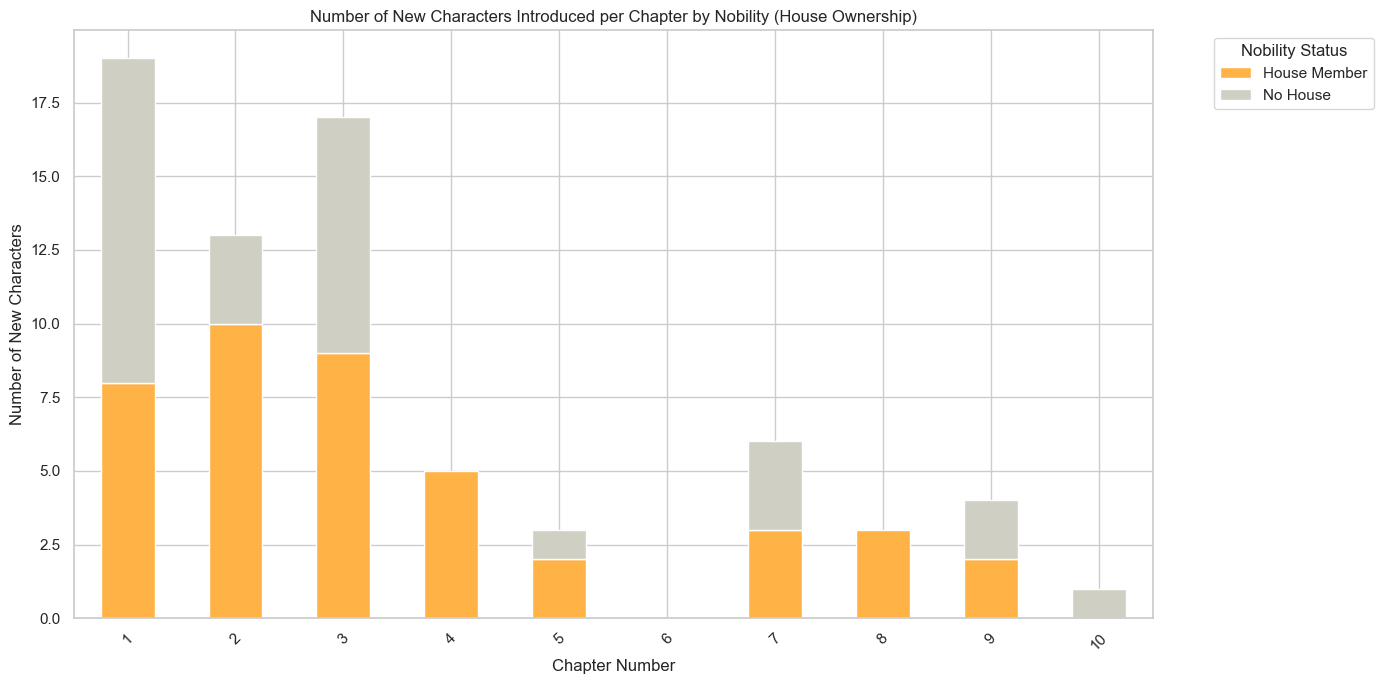

In [422]:
# Define pastel colors for nobility
nobility_colors = {
    'House Member': '#FFB347',  # Pastel Orange
    'No House': '#CFCFC4' # Pastel Gray
}

# Define nobility categories
nobility_categories = ['House Member', 'No House']

# Filter for nobility categories
nobility_data = exploded_categories[exploded_categories['categories_list'].isin(nobility_categories)]

# Count new characters per nobility and chapter
nobility_counts = nobility_data.groupby(['first_appearance_chapter_number', 'categories_list']).size().reset_index(name='count')

# Pivot the data to have nobility status as columns
nobility_pivot = nobility_counts.pivot(index='first_appearance_chapter_number', columns='categories_list', values='count').fillna(0)

# Reindex to include all chapters
nobility_pivot = nobility_pivot.reindex(range(1, total_chapters + 1), fill_value=0)

# Plotting Nobility
plt.figure(figsize=(14, 7))
nobility_pivot.plot(kind='bar', stacked=True, figsize=(14,7), color=[nobility_colors.get(n, '#FFFFFF') for n in nobility_pivot.columns])
plt.title('Number of New Characters Introduced per Chapter by Nobility (House Ownership)')
plt.xlabel('Chapter Number')
plt.ylabel('Number of New Characters')
plt.legend(title='Nobility Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8.7 Plotting New Characters Introduced by Rank (Title Possession)

This plot distinguishes between characters who possess titles and those who do not, showing their introductions per chapter with associated pastel colors.

<Figure size 1400x700 with 0 Axes>

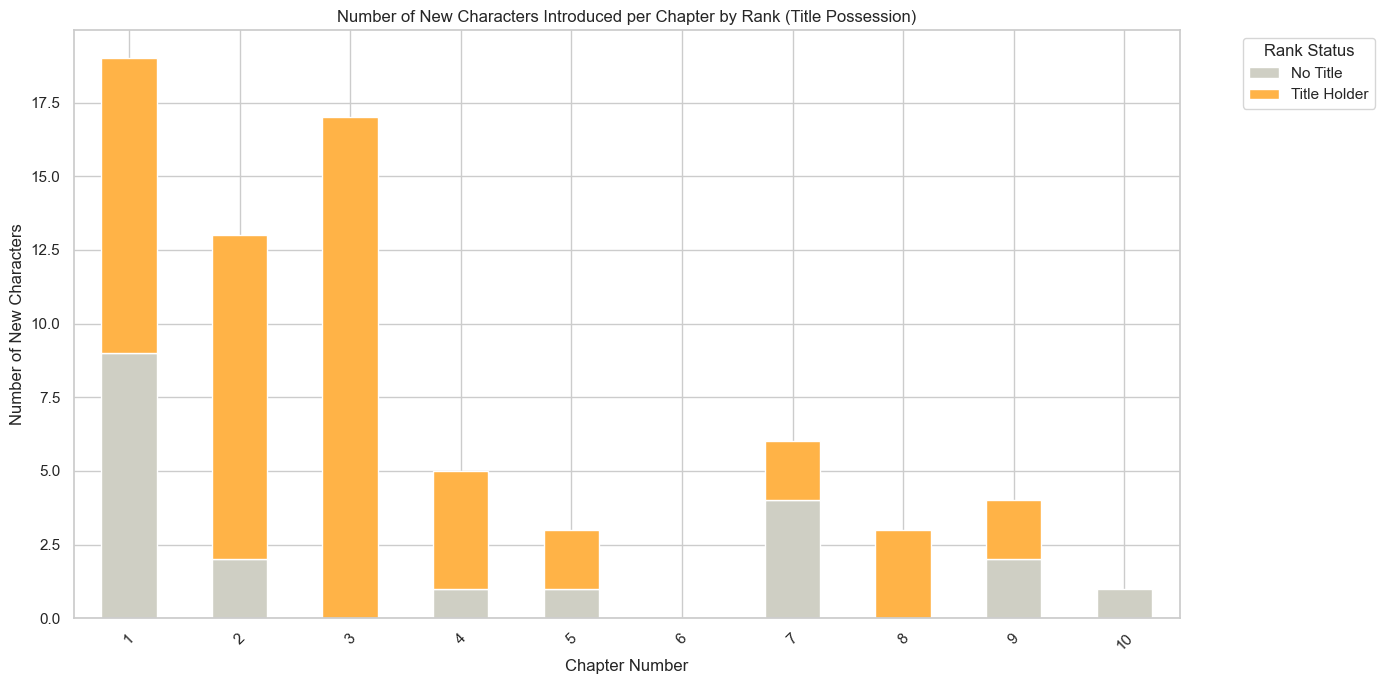

In [423]:
# Define pastel colors for rank
rank_colors = {
    'Title Holder': '#FFB347',  # Pastel Orange
    'No Title': '#CFCFC4'   # Pastel Gray
}

# Define rank categories
rank_categories = ['Title Holder', 'No Title']

# Filter for rank categories
rank_data = exploded_categories[exploded_categories['categories_list'].isin(rank_categories)]

# Count new characters per rank and chapter
rank_counts = rank_data.groupby(['first_appearance_chapter_number', 'categories_list']).size().reset_index(name='count')

# Pivot the data to have rank status as columns
rank_pivot = rank_counts.pivot(index='first_appearance_chapter_number', columns='categories_list', values='count').fillna(0)

# Reindex to include all chapters
rank_pivot = rank_pivot.reindex(range(1, total_chapters + 1), fill_value=0)

# Plotting Rank
plt.figure(figsize=(14, 7))
rank_pivot.plot(kind='bar', stacked=True, figsize=(14,7), color=[rank_colors.get(r, '#FFFFFF') for r in rank_pivot.columns])
plt.title('Number of New Characters Introduced per Chapter by Rank (Title Possession)')
plt.xlabel('Chapter Number')
plt.ylabel('Number of New Characters')
plt.legend(title='Rank Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8.8 Plotting New Characters Introduced by Culture

This plot shows the number of new characters introduced in each chapter based on their culture with associated pastel colors.

<Figure size 1400x700 with 0 Axes>

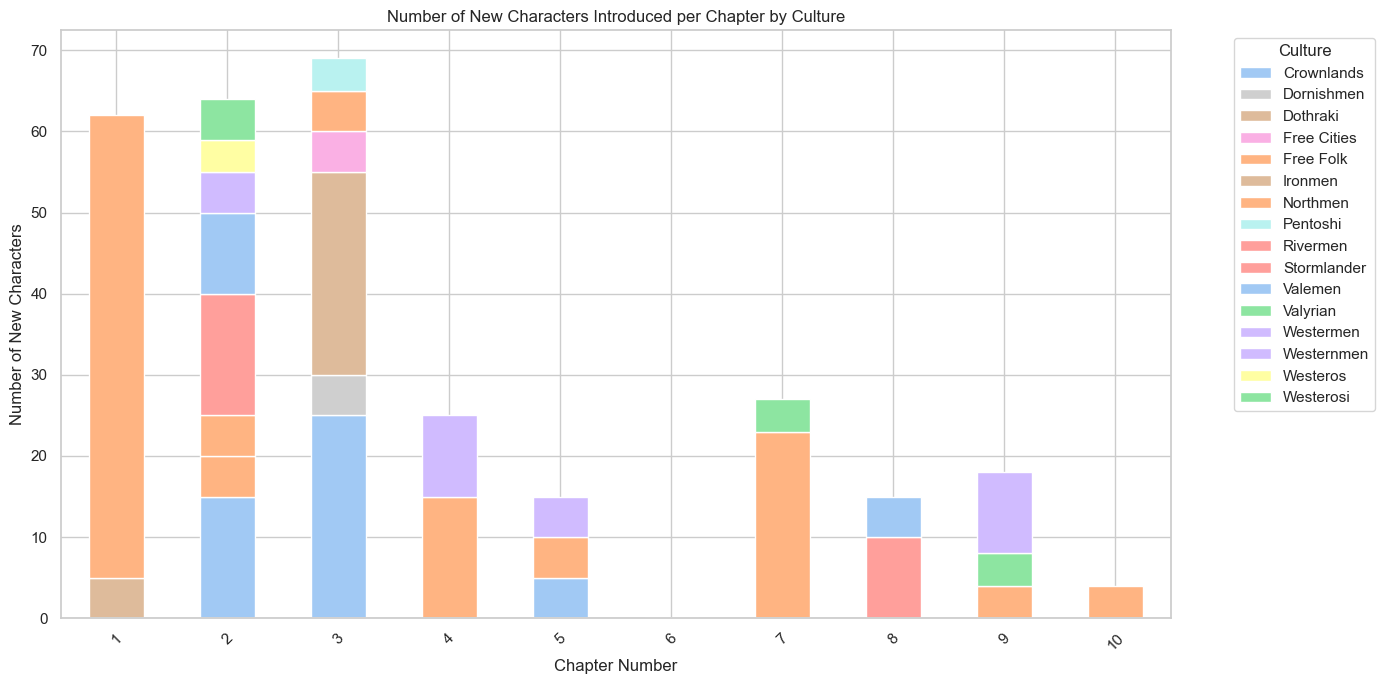

In [424]:
# Define pastel colors for cultures (example)
# You can customize these based on actual culture values in your data
unique_cultures = exploded_categories['culture'].dropna().unique()
num_cultures = len(unique_cultures)
if num_cultures > 0:
    culture_palette = sns.color_palette("pastel", num_cultures)
    culture_colors = {culture: color for culture, color in zip(unique_cultures, culture_palette)}
else:
    culture_colors = {}

# Filter for culture categories
culture_data = exploded_categories.dropna(subset=['culture'])

# Count new characters per culture and chapter
culture_counts = culture_data.groupby(['first_appearance_chapter_number', 'culture']).size().reset_index(name='count')

# Pivot the data to have cultures as columns
culture_pivot = culture_counts.pivot(index='first_appearance_chapter_number', columns='culture', values='count').fillna(0)

# Reindex to include all chapters
culture_pivot = culture_pivot.reindex(range(1, total_chapters + 1), fill_value=0)

# Assign colors based on culture_palette
culture_colors_plot = [culture_colors.get(c, '#FFFFFF') for c in culture_pivot.columns]

# Plotting Culture
plt.figure(figsize=(14, 7))
culture_pivot.plot(kind='bar', stacked=True, figsize=(14,7), color=culture_colors_plot)
plt.title('Number of New Characters Introduced per Chapter by Culture')
plt.xlabel('Chapter Number')
plt.ylabel('Number of New Characters')
plt.legend(title='Culture', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8.9 Plotting Cumulative Number of Characters Over Chapters

This plot illustrates the cumulative growth of unique characters throughout the chapters.

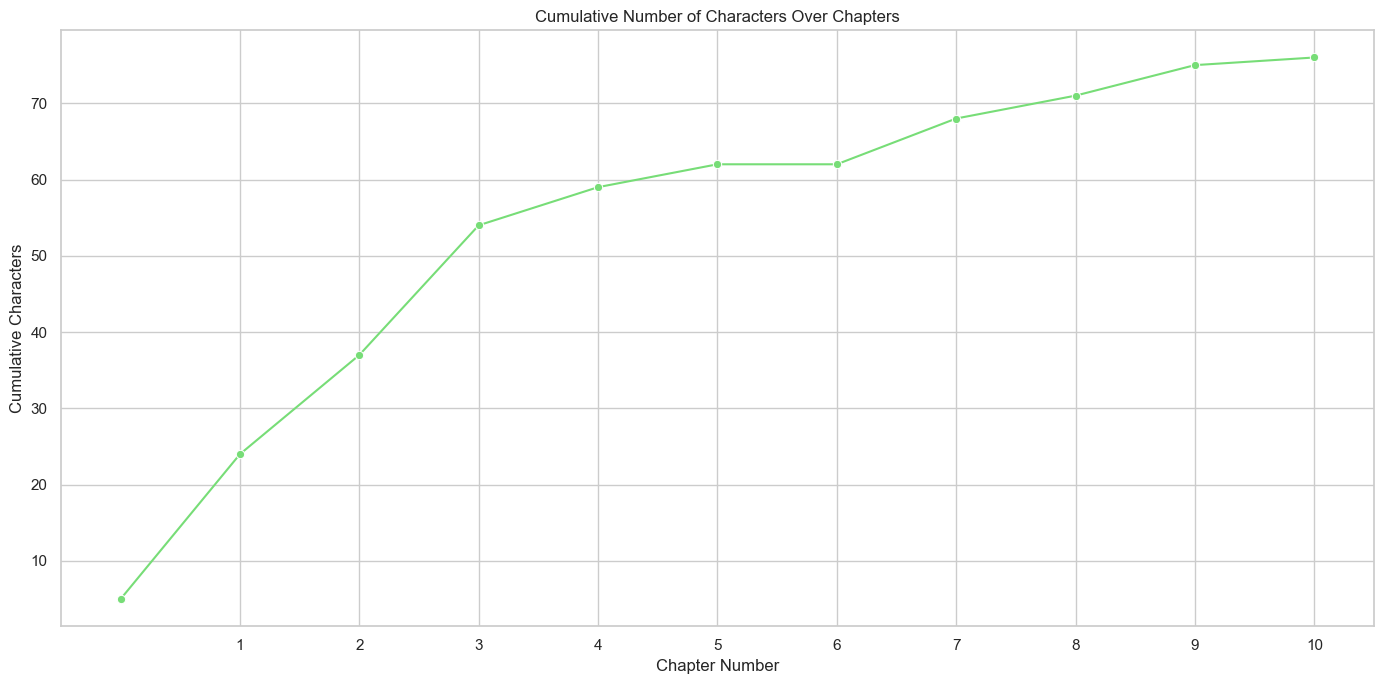

In [425]:
# Plotting the cumulative number of characters over chapters
plt.figure(figsize=(14, 7))
sns.lineplot(x='chapter_number', y='cumulative_characters', data=new_characters_per_chapter, marker='o', color='#77DD77')  # Pastel Green
plt.title('Cumulative Number of Characters Over Chapters')
plt.xlabel('Chapter Number')
plt.ylabel('Cumulative Characters')
plt.xticks(range(1, total_chapters + 1))
plt.tight_layout()
plt.show()

## 9. Creating Per-Chapter Summary DataFrame

In this section, we create a detailed per-chapter summary DataFrame that includes:

- Number of unique characters (total, male, female)
- Number of characters introduced (total, male, female)
- Bechdel Test results for each chapter
- Percentage of dialogues passing the Bechdel Test per scene and per chapter

This DataFrame will provide a comprehensive overview of character dynamics and representation throughout the story.

### 9.1 Defining the Bechdel Test Function

We define functions to evaluate the Bechdel Test for dialogues and scenes. The Bechdel Test requires:

1. The work has at least two women.
2. They talk to each other.
3. They talk about something other than a man.

We implement a simplified version of the test based on available data.

In [426]:
def bechdel_test_dialogue(dialogue_text, speakers, addressees):
    """
    Determine if a dialogue passes the Bechdel Test.

    Parameters:
    - dialogue_text (str): The text of the dialogue.
    - speakers (list of dict): List of speaker dictionaries.
    - addressees (list of dict): List of addressee dictionaries.

    Returns:
    - bool: True if the dialogue passes the Bechdel Test, False otherwise.
    """
    # Identify female speakers and addressees
    female_speakers = [s for s in speakers if s.get('gender') == 'Female']
    female_addressees = [a for a in addressees if a.get('gender') == 'Female']

    # Total unique female characters in the dialogue
    unique_female_interactors = set([s['name'] for s in female_speakers] + [a['name'] for a in female_addressees])

    if len(unique_female_interactors) < 2:
        return False  # Less than two women

    # Simple keyword check to determine if not about a man
    # This can be replaced with a more sophisticated NLP approach
    if any(word in dialogue_text.lower() for word in ['he', 'him', 'his', 'male', 'man']):
        return False  # Dialogue is about a man

    return True  # Passes the test

def bechdel_test_scene(dialogues_in_scene):
    """
    Determine if a scene passes the Bechdel Test based on its dialogues.

    Parameters:
    - dialogues_in_scene (DataFrame): DataFrame containing dialogues in the scene.

    Returns:
    - bool: True if the scene passes the Bechdel Test, False otherwise.
    - float: Percentage of dialogues that pass the Bechdel Test.
    """
    # Check if any dialogue in the scene passes the Bechdel Test
    bechdel_pass = dialogues_in_scene['dialogue_bechdel_pass'].any()
    
    # Calculate the percentage of dialogues that pass the Bechdel Test
    pass_percentage = dialogues_in_scene['dialogue_bechdel_pass'].mean() * 100
    
    return bechdel_pass, pass_percentage

def bechdel_test_chapter(scenes_in_chapter):
    """
    Determine if a chapter passes the Bechdel Test based on its scenes.

    Parameters:
    - scenes_in_chapter (DataFrame): DataFrame containing scenes in the chapter.

    Returns:
    - bool: True if the chapter passes the Bechdel Test, False otherwise.
    """
    # Check if any scene in the chapter passes the Bechdel Test
    return scenes_in_chapter['scene_bechdel_pass'].any()

### 9.2 Applying the Bechdel Test to Dialogues

We apply the Bechdel Test to each dialogue in the `dialogues_df` DataFrame and update the DataFrame with the results.

In [427]:
# Apply the Bechdel Test to each dialogue
def apply_bechdel_test_to_dialogue(row):
    dialogue_text = row['dialogue_text']
    speakers = [row['dialogue_speaker']] if isinstance(row['dialogue_speaker'], dict) else []
    addressees = row['dialogue_addressees'] if isinstance(row['dialogue_addressees'], list) else []
    return bechdel_test_dialogue(dialogue_text, speakers, addressees)

dialogues_df['dialogue_bechdel_pass'] = dialogues_df.apply(apply_bechdel_test_to_dialogue, axis=1)

# Save the updated dialogues DataFrame to CSV
dialogues_df.to_csv(os.path.join(output_dir, 'dialogues.csv'), index=False)

# Display the first 10 rows with Bechdel Test results
print("Dialogues DataFrame with Bechdel Test (first 10 rows):")
display(dialogues_df.head())

Dialogues DataFrame with Bechdel Test (first 10 rows):


,book_name,chapter_number,chapter_title,chapter_year,scene_id,scene_location,scene_time,dialogue_text,dialogue_speaker,dialogue_addressees,dialogue_listeners,dialogue_mentions,dialogue_about_characters,dialogue_word_count,dialogue_sentiment,dialogue_bechdel_pass
0,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,We should start back. The wildlings are dead.,"{'name': 'Gared', 'house(s)': None, 'title(s)'...","[{'name': 'Waymar Royce', 'house(s)': ['Royce'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",[],[],8,-0.1,False
1,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,Do the dead frighten you?,"{'name': 'Waymar Royce', 'house(s)': ['Royce']...","[{'name': 'Gared', 'house(s)': None, 'title(s)...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",[],[],5,-0.2,False
2,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,Dead is dead. We have no business with the dead.,"{'name': 'Gared', 'house(s)': None, 'title(s)'...","[{'name': 'Waymar Royce', 'house(s)': ['Royce'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",[],[],10,-0.2,False
3,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,Are they dead? What proof have we?,"{'name': 'Waymar Royce', 'house(s)': ['Royce']...","[{'name': 'Gared', 'house(s)': None, 'title(s)...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",[],[],7,-0.2,False
4,A Game of Thrones,0,Prologue,297,0,The Haunted Forest,Evening,"Will saw them. If he says they are dead, that'...","{'name': 'Gared', 'house(s)': None, 'title(s)'...","[{'name': 'Waymar Royce', 'house(s)': ['Royce'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...","[{'name': 'Will', 'house(s)': None, 'title(s)'...",14,-0.1,False


### 9.3 Applying the Bechdel Test to Scenes

We evaluate each scene to determine if it passes the Bechdel Test based on its dialogues.

In [428]:
# Initialize a column for Bechdel Test in scenes_df
scenes_df['scene_bechdel_pass'] = False
scenes_df['scene_bechdel_pass_percentage'] = 0.0

# Iterate through each scene to evaluate the Bechdel Test
for index, scene in scenes_df.iterrows():
    chapter_number = scene['chapter_number']
    scene_id = scene['scene_id']
    
    # Get all dialogues in the current scene
    dialogues_in_scene = dialogues_df[
        (dialogues_df['chapter_number'] == chapter_number) &
        (dialogues_df['scene_id'] == scene_id)
    ]
    
    # Evaluate the Bechdel Test for the scene
    scene_bechdel_pass, pass_percentage = bechdel_test_scene(dialogues_in_scene)
    scenes_df.at[index, 'scene_bechdel_pass'] = scene_bechdel_pass
    scenes_df.at[index, 'scene_bechdel_pass_percentage'] = pass_percentage

# Save the updated scenes DataFrame to CSV
scenes_df.to_csv(os.path.join(output_dir, 'scenes.csv'), index=False)

# Display the first few scenes with Bechdel Test results
print("\nScenes DataFrame with Bechdel Test (first 5 rows):")
display(scenes_df.head())


Scenes DataFrame with Bechdel Test (first 5 rows):


,book_name,chapter_title,chapter_number,scene_id,location,time,num_dialogues,num_males,num_females,themes,scene_bechdel_pass,scene_bechdel_percent,scene_bechdel_pass_percentage
0,A Game of Thrones,Prologue,0,0,The Haunted Forest,Evening,36,5,2,"[Fear, Death, Cold, Duty, Experience vs. Youth]",False,0.0,0.0
1,A Game of Thrones,Prologue,0,1,The Haunted Forest,Evening,17,3,0,"[Fear, Supernatural, Duty, Experience vs. Youth]",False,0.0,0.0
2,A Game of Thrones,Prologue,0,2,The Haunted Forest,Evening,12,3,0,"[Supernatural, Fear, Death, Courage, Honor]",False,0.0,0.0
3,A Game of Thrones,Bran I,1,0,Outside Winterfell,Morning,4,11,0,"[Justice, Honor, Duty, Courage]",False,0.0,0.0
4,A Game of Thrones,Bran I,1,1,Outside Winterfell,Morning,4,4,0,"[Courage vs. Fear, Brotherhood, Perception of ...",False,0.0,0.0


### 9.4 Compiling Per-Chapter Summary

We compile a summary for each chapter that includes:

- Total unique characters (total, male, female)
- Number of characters introduced (total, male, female)
- Bechdel Test result for the chapter
- Percentage of dialogues passing the Bechdel Test per chapter

This summary is stored in a new DataFrame and exported as a CSV file.

In [429]:
# Initialize a DataFrame for chapter summaries
chapter_summary = pd.DataFrame({
    'chapter_number': range(1, total_chapters + 1),
    'chapter_title': '',
    'total_unique_characters': 0,
    'total_unique_males': 0,
    'total_unique_females': 0,
    'total_characters_introduced': 0,
    'new_males': 0,
    'new_females': 0,
    'bechdel_pass': False,
    'percentage_dialogues_pass_bechdel': 0.0
})

# Populate chapter titles
# Assuming each chapter has a unique title
chapter_titles = scenes_df.groupby('chapter_number')['chapter_title'].first().to_dict()
chapter_summary['chapter_title'] = chapter_summary['chapter_number'].map(chapter_titles)

# Populate total unique characters per chapter
for chapter in chapter_summary['chapter_number']:
    # Get all characters up to the current chapter
    chars_up_to_chapter = characters_first_appearance[
        characters_first_appearance['first_appearance_chapter_number'] <= chapter
    ]
    chapter_summary.loc[chapter_summary['chapter_number'] == chapter, 'total_unique_characters'] = chars_up_to_chapter['name'].nunique()
    chapter_summary.loc[chapter_summary['chapter_number'] == chapter, 'total_unique_males'] = chars_up_to_chapter[chars_up_to_chapter['gender'] == 'Male']['name'].nunique()
    chapter_summary.loc[chapter_summary['chapter_number'] == chapter, 'total_unique_females'] = chars_up_to_chapter[chars_up_to_chapter['gender'] == 'Female']['name'].nunique()
    
    # Number of characters introduced in the current chapter
    introduced_chars = characters_first_appearance[characters_first_appearance['first_appearance_chapter_number'] == chapter]
    chapter_summary.loc[chapter_summary['chapter_number'] == chapter, 'total_characters_introduced'] = introduced_chars['name'].nunique()
    chapter_summary.loc[chapter_summary['chapter_number'] == chapter, 'new_males'] = introduced_chars[introduced_chars['gender'] == 'Male']['name'].nunique()
    chapter_summary.loc[chapter_summary['chapter_number'] == chapter, 'new_females'] = introduced_chars[introduced_chars['gender'] == 'Female']['name'].nunique()
    
    # Determine if the chapter passes the Bechdel Test
    # Get all scenes in the chapter
    scenes_in_chapter = scenes_df[scenes_df['chapter_number'] == chapter]
    # Check if any scene in the chapter passes the Bechdel Test
    chapter_pass = scenes_in_chapter['scene_bechdel_pass'].any()
    chapter_summary.loc[chapter_summary['chapter_number'] == chapter, 'bechdel_pass'] = chapter_pass

# Calculating percentage of dialogues passing the Bechdel Test per chapter
dialogues_pass_bechdel_per_chapter = dialogues_df.groupby('chapter_number')['dialogue_bechdel_pass'].sum().reset_index(name='dialogues_pass_bechdel')
dialogues_count_per_chapter = dialogues_df.groupby('chapter_number').size().reset_index(name='total_dialogues')
chapter_summary = chapter_summary.merge(dialogues_pass_bechdel_per_chapter, on='chapter_number', how='left')
chapter_summary = chapter_summary.merge(dialogues_count_per_chapter, on='chapter_number', how='left')
chapter_summary['percentage_dialogues_pass_bechdel'] = (chapter_summary['dialogues_pass_bechdel'] / chapter_summary['total_dialogues']) * 100
chapter_summary['percentage_dialogues_pass_bechdel'] = chapter_summary['percentage_dialogues_pass_bechdel'].fillna(0)

# Round the percentages to two decimal places
chapter_summary['percentage_dialogues_pass_bechdel'] = chapter_summary['percentage_dialogues_pass_bechdel'].round(2)

# Save the chapter summary DataFrame to CSV
chapter_summary.to_csv(os.path.join(output_dir, 'chapters.csv'), index=False)

# Display the chapter summary
print("\nChapter Summary DataFrame:")
display(chapter_summary)


Chapter Summary DataFrame:


,chapter_number,chapter_title,total_unique_characters,total_unique_males,total_unique_females,total_characters_introduced,new_males,new_females,bechdel_pass,percentage_dialogues_pass_bechdel,dialogues_pass_bechdel,total_dialogues
0,1,Bran I,24,15,3,19,10,3,False,0.00,0,68
1,2,Catelyn I,37,25,6,13,10,3,False,0.00,0,39
2,3,Daenerys I,54,39,9,17,14,3,True,4.76,2,42
3,4,Eddard I,59,43,10,5,4,1,False,0.00,0,56
4,5,Jon I,62,45,11,3,2,1,False,0.00,0,56
5,6,Catelyn II,62,45,11,0,0,0,False,0.00,0,88
6,7,Arya I,68,48,14,6,3,3,True,10.00,6,60
7,8,Bran II,71,51,14,3,3,0,False,0.00,0,33
8,9,Tyrion I,75,54,15,4,3,1,False,0.00,0,58
9,10,Jon II,76,55,15,1,1,0,False,0.00,0,65
